# Imports

In [8]:
!pip install word2ket

  Using cached word2ket-0.0.2-py3-none-any.whl (7.7 kB)
  Using cached gpytorch-1.11-py3-none-any.whl (266 kB)
  Using cached linear_operator-0.5.2-py3-none-any.whl (175 kB)
  Using cached jaxtyping-0.2.25-py3-none-any.whl (39 kB)
  Using cached typeguard-2.13.3-py3-none-any.whl (17 kB)



[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
#!pip install torchtext
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
import torchtext
import torch
from torch import nn,optim
from time import time

In [2]:
data = pd.read_csv("dataframe.csv")
print(data)



      Unnamed: 0                                               text  encoded
0              0  The soil I’m walking over comes    from deeper...    False
1              1  the close air of the earth whence she derived ...     True
2              2  Lyric night of the lingering Indian Summer,\nS...    False
3              3  “Percussus sum sicut foenum, et aruit cor meum...    False
4              4  I should be happy with my lot: A wife and moth...    False
...          ...                                                ...      ...
4789        4789  office has never really is its oldest daughter...     True
4790        4790  soot from her car with suitcases and hugged he...     True
4791        4791  Seeing in crowded restaurants the one you love...    False
4792        4792  flower sweet as I can never forsake And Fortun...     True
4793        4793  Echo that loved hid within a wood Would to her...    False

[4794 rows x 3 columns]


Creating tokenizer and vocabulary

In [3]:
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.nn.utils import rnn
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2)


tokenizer = get_tokenizer("basic_english")

def build_vocabulary(datasets):
    for dataset in datasets:
        #print(dataset)
        for text in dataset['text']:
            yield tokenizer(text)

vocab = build_vocab_from_iterator(build_vocabulary([data,data]), min_freq=3, specials=["<UNK>"])

vocab.set_default_index(vocab["<UNK>"])

for l in data['text']:
  tokens = tokenizer(l)
  indexes = vocab(tokens)


Creating Dataloader

In [4]:

class Text(Dataset):
  def __init__(self,df):
    self.df = df
    #print(df)

  def pad(self,seq):
    if len(seq)>140:
      return seq[:140]
    else:
      for i in range(140-len(seq)):
        seq.insert(0,0)
      return seq

  def __len__(self):
    return len(self.df['encoded'])
  def __getitem__(self,idx):
    
    return torch.tensor(self.pad(vocab(tokenizer(self.df['text'][idx])))) , int(self.df['encoded'][idx])

test_loader  = DataLoader(Text(test.reset_index()) , batch_size=4)
train_loader = DataLoader(Text(train.reset_index()) , batch_size=128)

for txt , tgt in test_loader:
  _
  #print(txt)
  #print(txt)
voc = len(vocab)
#print(tokens)

print(vocab(["<UNK>"]))

[0]


In [5]:
print(test)
print(train)

      Unnamed: 0                                               text  encoded
1427        1427  Carried her unprotesting out the door. Kicked ...    False
2896        2896  while munching cookies. Its slope gone gaily g...     True
1246        1246  My sister and I went out to them with sugar cu...    False
3451        3451  One spring day I saw the shadow of a strawberr...    False
2382        2382  The fair rolled into town surprisingly intact,...    False
...          ...                                                ...      ...
3328        3328  which tree makes the maid. Even that lives I t...     True
3258        3258  She stood breast high amid the corn,\nClasped ...    False
4464        4464  lives drape itself and thin. Raising each othe...     True
3399        3399  thee Dost thou shalt be names whom society arr...     True
2723        2723  A Deaf Blind poet doesn’t like to read sitting...    False

[959 rows x 3 columns]
      Unnamed: 0                                    

Creating RNN

In [26]:

class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.embedding_layer = nn.Embedding(len(vocab),64)
        self.rnn = nn.RNN(64,32, 3, batch_first=True)
        self.linear1 = nn.Linear(32,32)
        self.linear2 = nn.Linear(32,2)
        self.act = nn.ReLU()
        self.out = nn.LogSoftmax(dim = 1)

    def forward(self, X_batch):
        embeddings = self.embedding_layer(X_batch)
        output, hidden = self.rnn(embeddings)
        return self.out(self.linear2(self.act(self.linear1(self.act(output[:,-1])))))

model = RNN()

print(model)


RNN(
  (embedding_layer): Embedding(18658, 64)
  (rnn): RNN(64, 32, num_layers=3, batch_first=True)
  (linear1): Linear(in_features=32, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=2, bias=True)
  (act): ReLU()
  (out): LogSoftmax(dim=1)
)


In [27]:
from word2ket import EmbeddingKet, EmbeddingKetXS , ketify,summary
summary(model)
#ketify(model,order = 8,rank = 4, use_EmbeddingKetXS= False)


Module Name                                                                           Total Parameters  Trainable Parameters # Elements in Trainable Parametrs       
Embedding(18658, 64)                                                                  1                 1                    1,194,112                               
RNN(64, 32, num_layers=3, batch_first=True)                                           12                12                   7,360                                   
Linear(in_features=32, out_features=32, bias=True)                                    2                 2                    1,056                                   
Linear(in_features=32, out_features=2, bias=True)                                     2                 2                    66                                      
ReLU()                                                                                0                 0                    0                                       
LogS

1202594

In [28]:
summary(model)

Module Name                                                                           Total Parameters  Trainable Parameters # Elements in Trainable Parametrs       
Embedding(18658, 64)                                                                  1                 1                    1,194,112                               
RNN(64, 32, num_layers=3, batch_first=True)                                           12                12                   7,360                                   
Linear(in_features=32, out_features=32, bias=True)                                    2                 2                    1,056                                   
Linear(in_features=32, out_features=2, bias=True)                                     2                 2                    66                                      
ReLU()                                                                                0                 0                    0                                       
LogS

1202594

In [37]:
accuracy = []
optimizer = optim.SGD(model.parameters(), lr=0.011, momentum=0.3)
criterion = nn.NLLLoss()
time0 = time()

Training

In [38]:
accuracy = []
epochs = 20
for e in range(epochs):
    running_loss = 0
    for text, tgt in train_loader:
        # Training pass
        optimizer.zero_grad()

        output = model(text)

        loss = criterion(output, tgt)

        #This is where the model learns by backpropagating
        loss.backward()
        #And optimizes its weights here
        optimizer.step()
        #print(loss.item())
        running_loss += loss.item()

    else:
        #print("\nTraining Time (in minutes) =",(time()-time0)/60)
        #print(output)
        print("\nEpoch {} - Training loss: {}".format(e+1, running_loss/len(test_loader)))
    correct_count, all_count = 0, 0
    for images,labels in test_loader:
      for i in range(len(labels)):
        img = images[i].view(1,-1)
        with torch.no_grad():
          logps = model(img)


        ps = torch.exp(logps)
        probab = list(ps.numpy()[0])
        pred_label = probab.index(max(probab))
        true_label = labels.numpy()[i]
        #print(pred_label)
        if(true_label == pred_label):
          correct_count += 1
        all_count += 1

    #print("Number Of Images Tested =", all_count)
    print("Model Accuracy =", (correct_count/all_count))
    accuracy.append((correct_count/all_count))



Epoch 1 - Training loss: 0.04883295198281606
Model Accuracy = 0.8832116788321168

Epoch 2 - Training loss: 0.061678497741619744
Model Accuracy = 0.7914494264859229

Epoch 3 - Training loss: 0.048910461366176605
Model Accuracy = 0.6110531803962461

Epoch 4 - Training loss: 0.056576991950472194
Model Accuracy = 0.7403545359749739

Epoch 5 - Training loss: 0.07224832028150559
Model Accuracy = 0.7403545359749739

Epoch 6 - Training loss: 0.06882342907289664
Model Accuracy = 0.7507820646506778

Epoch 7 - Training loss: 0.0662396602332592
Model Accuracy = 0.7632950990615224

Epoch 8 - Training loss: 0.06398002045849958
Model Accuracy = 0.7695516162669447

Epoch 9 - Training loss: 0.06169098503887653
Model Accuracy = 0.7872784150156413

Epoch 10 - Training loss: 0.058894057075182596
Model Accuracy = 0.7935349322210636

Epoch 11 - Training loss: 0.05566041097044945
Model Accuracy = 0.8070907194994786

Epoch 12 - Training loss: 0.05228903604050477
Model Accuracy = 0.8175182481751825

Epoch 13 

In [39]:
import matplotlib.pyplot as plt

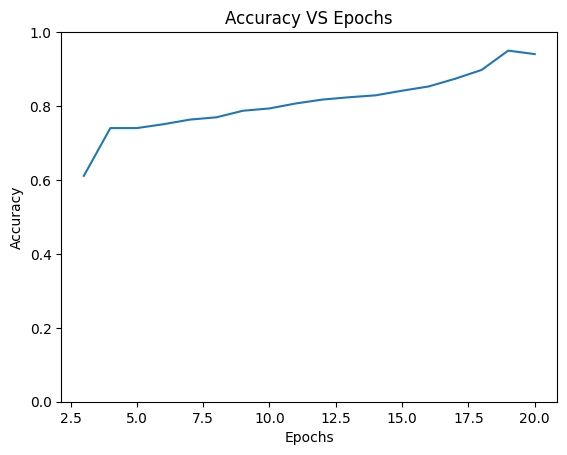

In [44]:
x_values = range(1, len(accuracy) + 1)

plt.plot(x_values[2:], accuracy[2:])
plt.ylim(0,1)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy VS Epochs')
    

plt.show()

#Texts for testing:

Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's

Even my brother is not like to speak with me. They treat me like aids patent.

